In [ ]:
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow import keras
from sklearn import model_selection
import imgaug.augmenters as iaa
import imgaug as ia
import matplotlib.cm as cm
import cv2
from IPython.display import Image, display
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
import os

In [ ]:
def resize_images(imgs, hight, width):
    seq = iaa.Resize({"height": hight, "width": width})
    aug = seq.augment_images(imgs)
    return aug

#generate CAM
def make_gradcam_heatmap(img_array, model,  layer_index, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model([model.inputs], 
          [model.layers[layer_index].output, model.output])
    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    #img = keras.preprocessing.image.load_img(img_path)
    #img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

In [ ]:
#load Cifar100 dataset
(x_origin_train, y_origin_train), (x_test,y_test) = keras.datasets.cifar100.load_data()

y_origin_train = y_origin_train.reshape(-1,)
y_test = y_test.reshape(-1,)
x_train, x_val, y_train, y_val = model_selection.train_test_split(
    x_origin_train,
    y_origin_train,
    test_size=10000,
    random_state=0,
    stratify=y_origin_train)
x_train = x_train/255.0
x_test = x_test/255.0
x_val = x_val/255.0

169017344/169001437 [==============================] - 3s 0us/step


In [ ]:
train_index = []
random.seed(0)
for i in range(100):
    train_index += (random.sample(list(np.where(y_train == i)[0]), 400))
random.shuffle(train_index)
sampled_x_train = x_train[train_index]
sampled_y_train = y_train[train_index]
del train_index

88


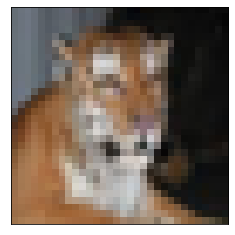

In [ ]:
#select images for CAM
test_image = sampled_x_train[226]
print(sampled_y_train[226])
plt.xticks([])
plt.yticks([])
plt.imshow(test_image)
plt.savefig('ex_')

In [ ]:
#load model without distance loss
model = keras.models.load_model('/content/drive/MyDrive/cifar100experiment/resnet/experiment/400_samples_seed_fix.h5')

tf.Tensor(88, shape=(), dtype=int64)
tf.Tensor(88, shape=(), dtype=int64)
tf.Tensor(88, shape=(), dtype=int64)
tf.Tensor(88, shape=(), dtype=int64)
tf.Tensor(88, shape=(), dtype=int64)


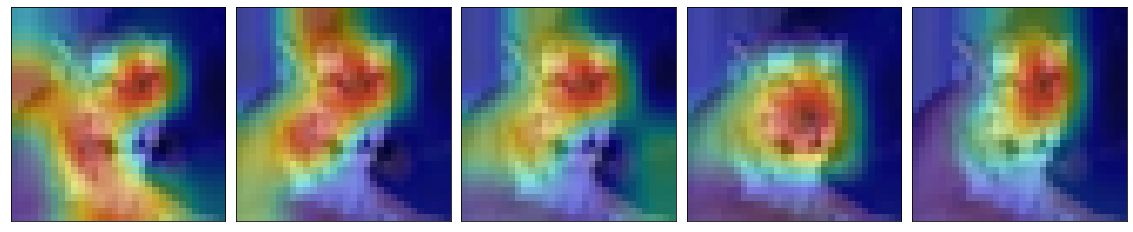

In [ ]:
#display CAM of models without distance loss
plt.figure(figsize=(20,8))
for i in range(1,6):
  model_index = i
  mmm = keras.models.Model(inputs=model.layers[model_index].inputs,outputs=model.layers[model_index].output[0])
  print(tf.argmax(mmm(test_image.reshape(1,32,32,3))[0]))
  #mmm.layers[-1].activation = None
  heatmap = make_gradcam_heatmap(test_image.reshape(1,32,32,3),mmm,layer_index=42,pred_index=None)
  plt.subplot(1,5,i)
  plt.subplots_adjust(wspace=0.05,hspace=0.05)
  plt.imshow(test_image)
  plt.imshow(resize_images([heatmap], 32,32)[0], alpha=0.4, cmap='jet')
  plt.xticks([])
  plt.yticks([])
plt.savefig('ex_cifar100_ResNet_')
plt.show()

In [ ]:
#load model with distance loss
model1 = keras.models.load_model('/content/drive/MyDrive/cifar100experiment/resnet/experiment/400_samples_seed_fix_m1_m10.h5')

tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)


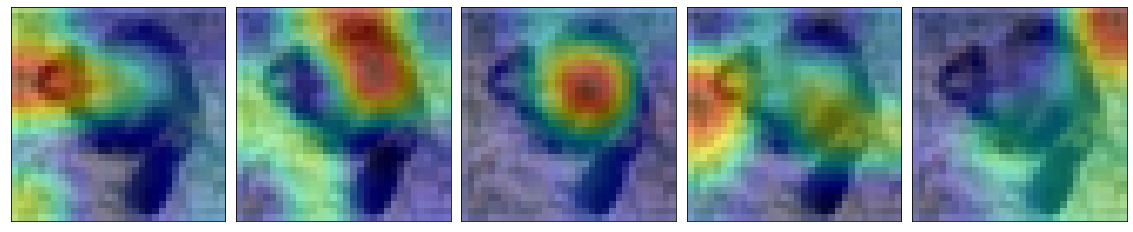

In [ ]:
#display CAM for models with distance loss
plt.figure(figsize=(20,8))
for i in range(1,6):
  model_index = i
  mmm1 = keras.models.Model(inputs=model1.layers[model_index].inputs,outputs=model1.layers[model_index].output[0])
  print(tf.argmax(mmm1(test_image.reshape(1,32,32,3))[0]))
  #mmm.layers[-1].activation = None
  heatmap = make_gradcam_heatmap(test_image.reshape(1,32,32,3),mmm1,layer_index=42,pred_index=None)
  plt.subplot(1,5,i)
  plt.subplots_adjust(wspace=0.05,hspace=0.05)
  plt.imshow(test_image)
  plt.imshow(resize_images([heatmap], 32,32)[0], alpha=0.4, cmap='jet')
  plt.xticks([])
  plt.yticks([])
plt.savefig('ex_cifar100_ResNet_d')
plt.show()